In [1]:
import os
os.chdir("../")

from data_management.DataManager import CALFData, collateGCN
import numpy as np
import torch 
from Model import ContextAwareModel, SpottingModel
from helpers.loss import ContextAwareLoss
from modules.train import trainer
import pickle
from dataclasses import dataclass
import matplotlib.pyplot as plt
from modules.Visualiser import collateVisGCN, Visualiser
import seaborn as sns
from helpers.classes import EVENT_DICTIONARY_V2_ALIVE as event_enc
from helpers.classes import get_K_params
import torch.nn as nn
import seaborn as sns

In [2]:
@dataclass
class Args:
    receptive_field = 12
    fps = 5
    chunks_per_epoch = 1824
    class_split = "alive"
    chunk_size = 60
    batch_size = 32
    input_channel = 13
    feature_multiplier=1
    backbone_player = "GCN"
    max_epochs=180
    load_weights=None
    model_name="Testing_Model"
    dim_capsule=16
    lambda_coord=5.0
    lambda_noobj=0.5
    patience=25
    LR=1e-03
    GPU=0 
    max_num_worker=1
    loglevel='INFO'
    annotation_nr = 10
    K_parameters = get_K_params(chunk_size)
    focused_annotation = None
    generate_augmented_data = True
    generate_artificial_targets = True
    # For spottting module
    sgementation_path = None
    freeze_model = None

# SEGMENTATION PART

In [3]:
args = Args
collate_fn = collateGCN

train_dataset = CALFData(split="train", args=args)
validation_dataset = CALFData(split="validate", args=args)

train_loader = torch.utils.data.DataLoader(train_dataset,
            batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)

validate_loader = torch.utils.data.DataLoader(validation_dataset,
            batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)

model = ContextAwareModel(args=args)
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=args.LR, 
                            betas=(0.9, 0.999), eps=1e-07, 
                            weight_decay=0, amsgrad=False)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, patience=args.patience)

losses = trainer(train_loader, validate_loader,
                    model, optimizer, scheduler, 
                    criterion,
                    model_name=args.model_name,
                    max_epochs=args.max_epochs, 
                    save_dir=f"models/artificial_targets_GCN.pth.tar")

del train_dataset, validation_dataset, train_loader, validate_loader

with open(f'results/artificial_targets_GCN.pkl', 'wb') as file:
    pickle.dump(losses, file)

Get labels & features: 100%|██████████| 8/8 [02:10<00:00, 16.25s/it]
Train 1: Time 2.590s (it:2.651s) Data:0.836s (it:0.753s) Loss 1.2045e-01 : 100%|████████████████████████████████████████████████| 57/57 [02:27<00:00,  2.59s/it]
Evaluate 1: Time 1.586s (it:1.385s) Data:0.724s (it:0.635s) Loss 1.2913e-01 : 100%|█████████████████████████████████████████████| 57/57 [01:30<00:00,  1.59s/it]
Train 2: Time 2.644s (it:2.395s) Data:0.833s (it:0.736s) Loss 1.0789e-01 : 100%|████████████████████████████████████████████████| 57/57 [02:30<00:00,  2.64s/it]
Evaluate 2: Time 1.613s (it:1.549s) Data:0.722s (it:0.644s) Loss 1.1824e-01 : 100%|█████████████████████████████████████████████| 57/57 [01:31<00:00,  1.61s/it]
Train 3: Time 2.631s (it:2.326s) Data:0.842s (it:0.721s) Loss 1.0551e-01 : 100%|████████████████████████████████████████████████| 57/57 [02:29<00:00,  2.63s/it]
Evaluate 3: Time 1.591s (it:1.522s) Data:0.720s (it:0.657s) Loss 1.0847e-01 : 100%|███████████████████████████████████████████

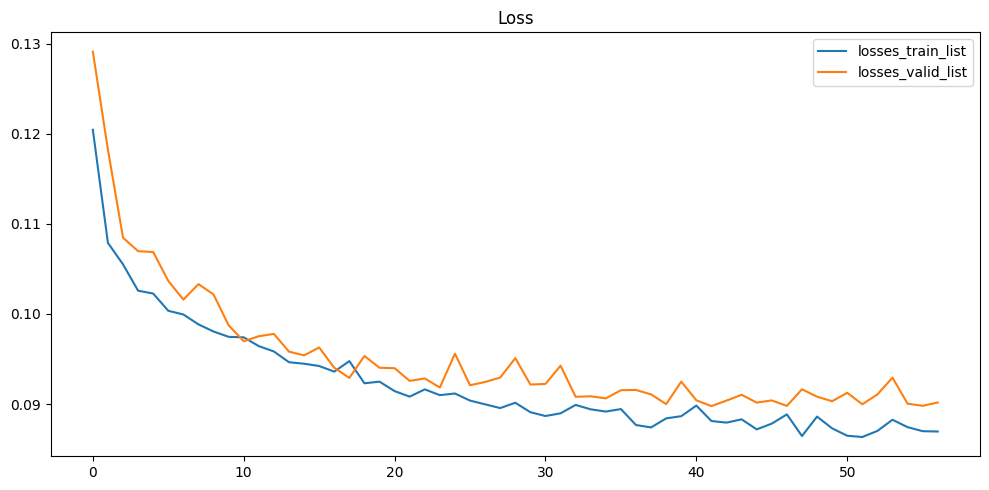

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
loss_pairs = [
    ('losses_train_list', 'losses_valid_list'), 
    ]
# Loop through each subplot

loss_pair = loss_pairs[0]
for loss in loss_pair:
    ax.plot(losses.__dict__[loss], label=loss)
    ax.set_title(loss)

# Adjust layout for better spacing
plt.tight_layout()
plt.legend()
plt.title("Loss")
# Show the plots
plt.show()

Data preprocessing: 100%|██████████| 1/1 [00:08<00:00,  8.69s/it]


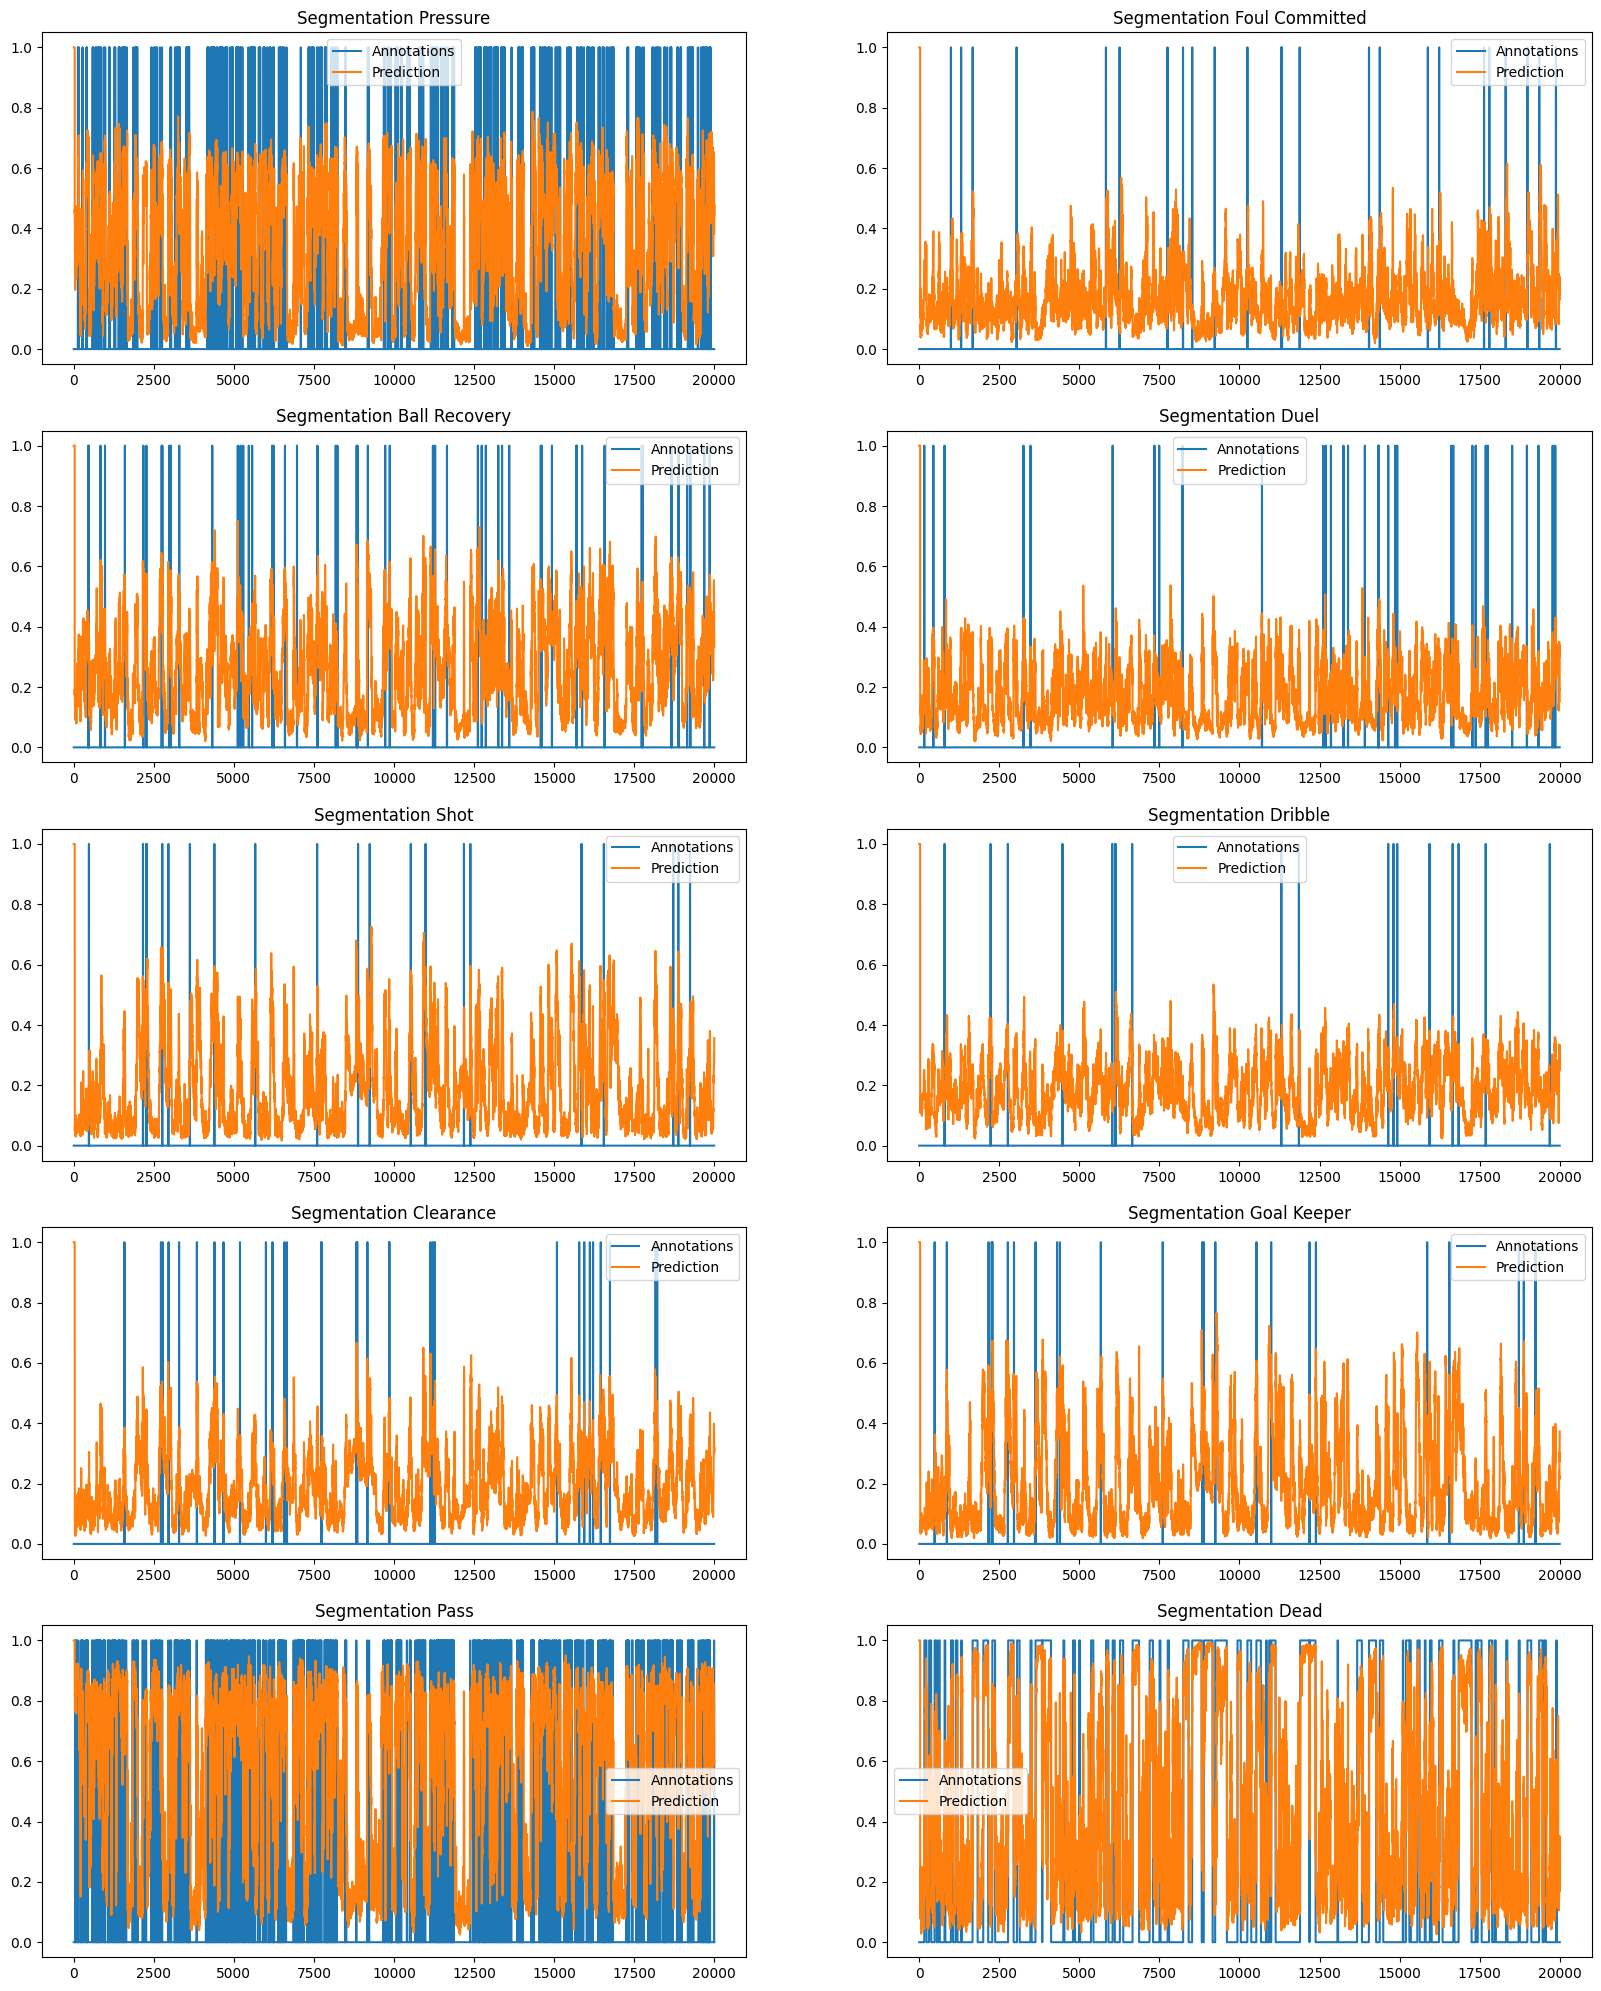

(<Figure size 2000x2500 with 10 Axes>,
 array([[<Axes: title={'center': 'Segmentation Pressure'}>,
         <Axes: title={'center': 'Segmentation Foul Committed'}>],
        [<Axes: title={'center': 'Segmentation Ball Recovery'}>,
         <Axes: title={'center': 'Segmentation Duel'}>],
        [<Axes: title={'center': 'Segmentation Shot'}>,
         <Axes: title={'center': 'Segmentation Dribble'}>],
        [<Axes: title={'center': 'Segmentation Clearance'}>,
         <Axes: title={'center': 'Segmentation Goal Keeper'}>],
        [<Axes: title={'center': 'Segmentation Pass'}>,
         <Axes: title={'center': 'Segmentation Dead'}>]], dtype=object))

In [3]:
args = Args
collate_fn = collateVisGCN
model_path = f"models/artificial_targets_GCN.pth.tar"
model = torch.load(model_path)
model.eval()
visualiser = Visualiser(collate_fn, args, model, smooth_rate=None, val=True)
visualiser.plot_predictions(frame_threshold=20000, save_dir=None, annotation=None)

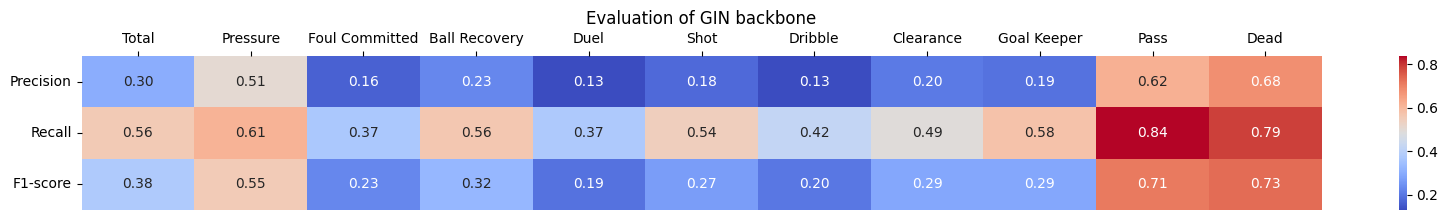

In [4]:
precision, recall, f1_score, _ = visualiser.norm_evaluation_segmentation()
precision = np.concatenate((np.array([np.mean(precision)]), precision))
recall = np.concatenate((np.array([np.mean(recall)]), recall))
f1_score = np.concatenate((np.array([np.mean(f1_score)]), f1_score))

cols = ["Total"] + list(event_enc.keys())
rows = ["Precision", "Recall", "F1-score"]

fig = plt.figure(figsize=(20, 2))

total_scores = np.concatenate((precision, recall, f1_score))
# ax1.set_title("Precision scores")
ax = sns.heatmap(total_scores.reshape(3,-1), annot=True, cmap="coolwarm", fmt=".2f", xticklabels=True, yticklabels=True)
ax.set_xticklabels(cols, rotation=0)
ax.xaxis.tick_top()
ax.set_yticklabels(rows, rotation=0)

plt.title("Evaluation of GIN backbone")
plt.show()

# SPOTTING PART

In [3]:
@dataclass
class Args:
    receptive_field = 12
    fps = 5
    chunks_per_epoch = 1824
    class_split = "alive"
    chunk_size = 60
    batch_size = 32
    input_channel = 13
    feature_multiplier=1
    backbone_player = "GCN"
    max_epochs=180
    load_weights=None
    model_name="Testing_Model"
    dim_capsule=16
    lambda_coord=5.0
    lambda_noobj=0.5
    patience=25
    LR=1e-03
    GPU=0 
    max_num_worker=1
    loglevel='INFO'
    annotation_nr = 10
    K_parameters = get_K_params(chunk_size)
    focused_annotation = None
    generate_augmented_data = True
    generate_artificial_targets = True
    # For spottting module
    sgementation_path = f"models/artificial_targets_GCN.pth.tar"
    freeze_model = True

In [6]:
args = Args
collate_fn = collateGCN

train_dataset = CALFData(split="train", args=args)
validation_dataset = CALFData(split="validate", args=args)

train_loader = torch.utils.data.DataLoader(train_dataset,
            batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)

validate_loader = torch.utils.data.DataLoader(validation_dataset,
            batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)

model = SpottingModel(args=args)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=args.LR, 
                            betas=(0.9, 0.999), eps=1e-07, 
                            weight_decay=0, amsgrad=False)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, patience=args.patience)

losses = trainer(train_loader, validate_loader,
                    model, optimizer, scheduler, 
                    criterion=criterion,
                    model_name=args.model_name,
                    max_epochs=args.max_epochs,
                    save_dir=f"models/spotting_artificial_targets_GCN.pth.tar",
                    train_seg=False)

with open(f'results/spotting.pkl', 'wb') as file:
    pickle.dump(losses, file)

Get labels & features: 100%|██████████| 8/8 [01:55<00:00, 14.47s/it]
Train 1: Time 1.718s (it:1.573s) Data:0.886s (it:0.754s) Loss 2.4254e-01 : 100%|████████████████████████████████████████████████| 57/57 [01:37<00:00,  1.72s/it]
Evaluate 1: Time 1.570s (it:1.486s) Data:0.735s (it:0.661s) Loss 7.6417e-02 : 100%|█████████████████████████████████████████████| 57/57 [01:29<00:00,  1.57s/it]
Train 2: Time 1.723s (it:1.493s) Data:0.811s (it:0.719s) Loss 1.0975e-01 : 100%|████████████████████████████████████████████████| 57/57 [01:38<00:00,  1.72s/it]
Evaluate 2: Time 1.673s (it:1.481s) Data:0.765s (it:0.673s) Loss 7.1119e-02 : 100%|█████████████████████████████████████████████| 57/57 [01:35<00:00,  1.67s/it]
Train 3: Time 1.696s (it:1.551s) Data:0.801s (it:0.716s) Loss 9.8351e-02 : 100%|████████████████████████████████████████████████| 57/57 [01:36<00:00,  1.70s/it]
Evaluate 3: Time 1.600s (it:1.470s) Data:0.753s (it:0.672s) Loss 7.2704e-02 : 100%|███████████████████████████████████████████

Data preprocessing: 100%|██████████| 1/1 [00:14<00:00, 14.05s/it]


(<Figure size 2000x2500 with 10 Axes>,
 array([[<Axes: title={'center': 'Spotting Pressure'}>,
         <Axes: title={'center': 'Spotting Foul Committed'}>],
        [<Axes: title={'center': 'Spotting Ball Recovery'}>,
         <Axes: title={'center': 'Spotting Duel'}>],
        [<Axes: title={'center': 'Spotting Shot'}>,
         <Axes: title={'center': 'Spotting Dribble'}>],
        [<Axes: title={'center': 'Spotting Clearance'}>,
         <Axes: title={'center': 'Spotting Goal Keeper'}>],
        [<Axes: title={'center': 'Spotting Pass'}>,
         <Axes: title={'center': 'Spotting Dead'}>]], dtype=object))

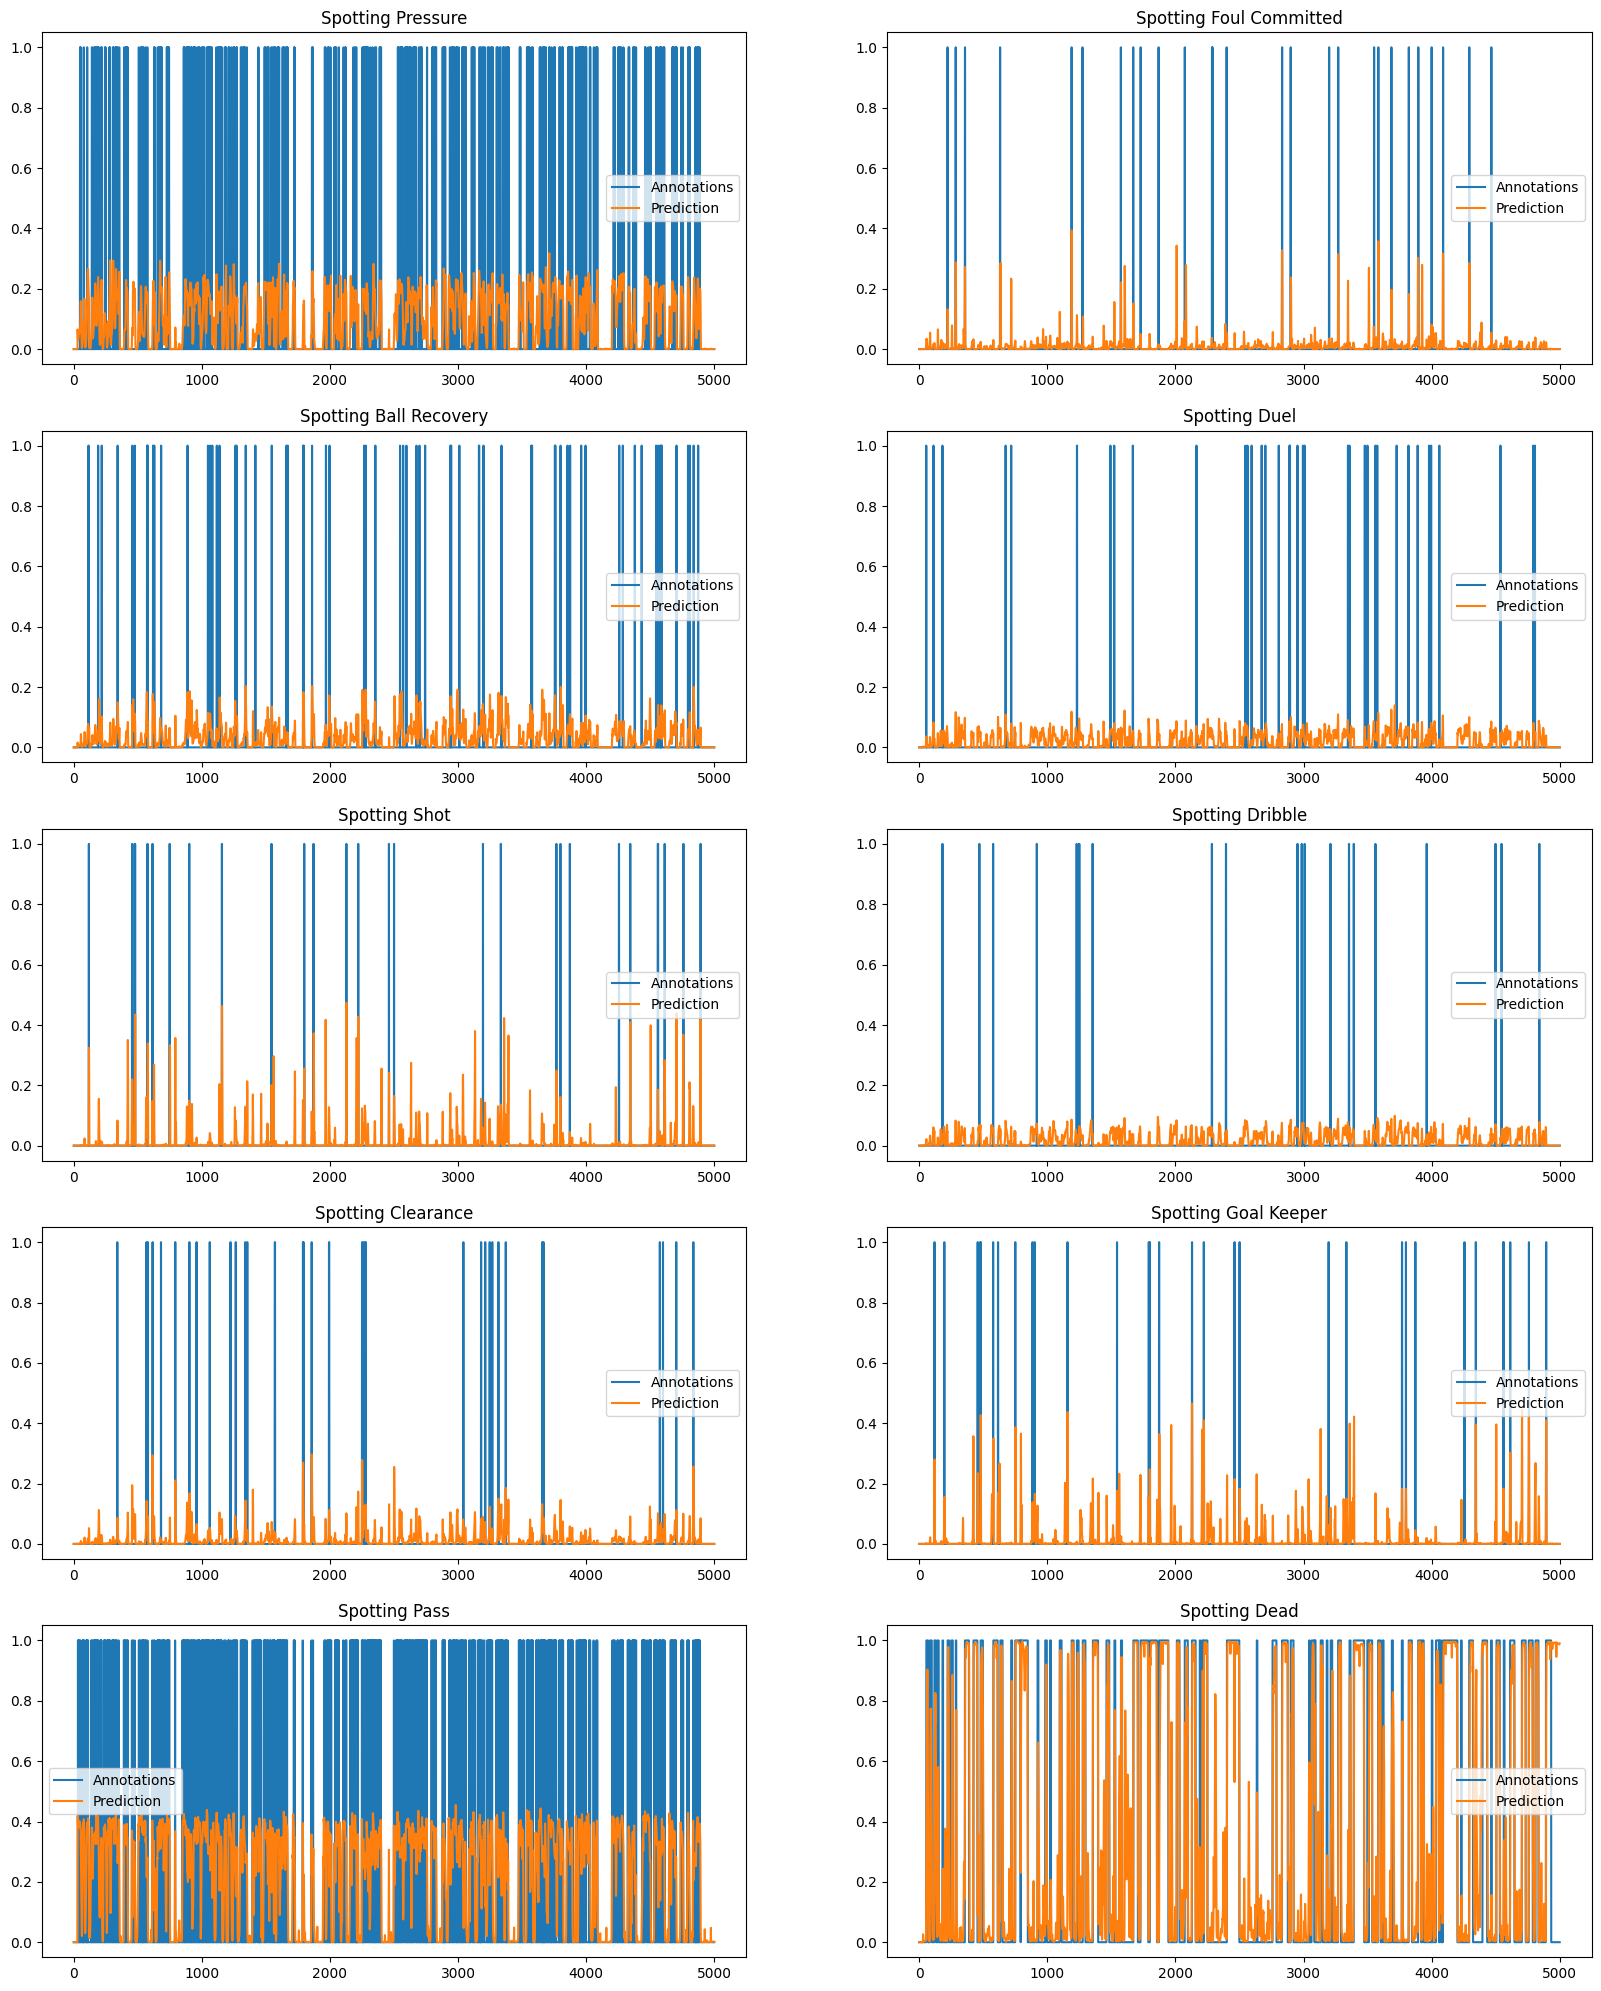

In [4]:
args = Args
collate_fn = collateVisGCN
model_path = "models/spotting_edge_attr_GCN.pth.tar"
model = torch.load(model_path)
visualiser = Visualiser(collate_fn, args, model, smooth_rate=None, val=True, seg_model=False)
visualiser.plot_predictions(frame_threshold=5000, save_dir="plots/PredictionsPlot.png", annotation=None)

In [5]:
visualiser.calculate_MAP()

array([0.28587518, 0.25323204, 0.252259  , 0.13116603, 0.04814149,
       0.31356811, 0.03074171, 0.22373106, 0.33288417, 0.3483372 ,
       0.92469094])